# NECA Funding Data

This workbook aims to explore the data potentially publishable from the NECA investment funding. It is presented in the form of a Jupyter notebook, which could be automated as a processing pipeline.

## Load Python libraries

The major library for data manipulation is PETL. We also require `thefuzz` for some fuzzy matching, and some reference data (Local Authority names)

In [1]:
from pathlib import Path

import petl as etl
from pipeline_utils.filesystem.paths import RAW_DATA, SITE
from pipeline_utils.reference.geo import la_names
from thefuzz.process import extractOne

In [2]:
OUT_DIR = SITE / 'data/neca/_data/'

## Duplicate the Pivot table

Read the outputs from the appropriate sheet of the spreadsheet, and apply numeric conversions.

In [3]:
outputs = (
    etl
    .fromxlsx(RAW_DATA / 'NECA/Culture Projects Outputs.xlsx', sheet='Culture Projects Outputs')
    .convertnumbers()
    .convert('category', lambda f: f.strip())
    .cache()
)

Prepare the data by the following method

* Filter the __Culture, creative and tourism__ `workstream`, and the __LAST_APPROVED__ `block_status`.
* `melt` the data into a long format with a column for `variable` (__forecast__ or __actual__), and a column for `value`.
* Drop the rows where value is `None`.

The table display is truncated.

In [4]:
report_data = (
    outputs
    .selecteq('workstream', 'Culture, creative and tourism')
    .selecteq('block_status', 'LAST_APPROVED')
    .melt(key=["category", "block_status"], variables=["forecast", "actual"])
    .selectnotnone('value')
)

report_data

category,block_status,variable,value
Number of cultural / tourism events taking place,LAST_APPROVED,actual,1
Numbers of attendees participating in a cultural tourism event,LAST_APPROVED,actual,20000
Number of enterprises receiving support,LAST_APPROVED,actual,5
Total participants supported,LAST_APPROVED,actual,100
Number of cultural / tourism events taking place,LAST_APPROVED,forecast,1


Then create a pivot report with a row per category, the columns being the variables, and the cells containing sums of the values.

`cut` reorders the columns, and `sort` reorders the rows. Finally, `replaceall` substitutes empty strings for `None`.

In [5]:
report = (
    report_data.pivot('category', 'variable', 'value', sum)
    .cut('category', 'forecast', 'actual')
    .sort('category')
    .replaceall(None, '')
)

report.displayall()

report.cutout('forecast').tocsv(OUT_DIR / 'project_outputs.csv')

category,forecast,actual
Creation / safeguarding of space for shared community and business activities,7,3
Direct Jobs Created,105,9
Direct Jobs Safeguarded,70,6
Disabled or deaf participants receiving support or an intervention,5,24
Economically Inactive participants engaged in job-searching upon leaving,,9
Economically inactive participants not in education or training receiving support or an intervention,,13
Employed residents who have progressed in employment,3,9
"Employed, including self-employed receiving support or an intervention",359,133
Indirect Jobs Created,105,11
Indirect Jobs Safeguarded,15,5


## Exploring allocations

This is an attempt to replicate some of the visualisations created for Arts Council England data from the base NECA data.

https://open-innovations.github.io/northumbria-culture-connect/arts-council/project-grants/

First we load the allocations data from the spreadsheet, filtering for rows with a defined Project Number (this removes the summary row, which would otherwise skew the numbers).

Note that it is not possible to completely replicate the Project Grants data, as the NECA data does not contain any date information. There is also some work to do to handle the North of Tyne area (i.e. the Combined Authority), which does not factor in the ACE data.

In [6]:
allocations = (
    etl
    .fromxlsx(RAW_DATA / 'NECA/Culture Projects Outputs.xlsx', sheet='Culture allocations')
    .selectnotnone('Project Number')
    .cache()
)

allocations = allocations.cutout('Private Match funding (£) ')

allocations

Project Number,Themes,Workstreams,Programme,Project,Applicant,Area,Project Officer,Status,Total cost (£),IF (£),Public Match funding (£),In-kind Match funding (£)
I0012,Place,"Culture, creative and tourism",Tour of Britain Cycle Race 2019,Tour of Britain Cycle Race 2019,Northumberland County Council,North Of Tyne,MA,Closed,369037,354037,None,None
I0062,Place,"Culture, creative and tourism",Tourism Programme,Remaining Tourism Programme,NTCA,North of Tyne,MA,Contracted,1289195,1189195,0,None
I0071,Place,"Culture, creative and tourism","Destination, Culture, Creative and Tourism",Culture and Creative Recovery Fund,NTCA,North Of Tyne,MA,Closed,3893945,2355632,None,None
I0089,Place,"Culture, creative and tourism",Tourism Programme,Lindisfarne Gospels,Newcastle City Council,Newcastle,MA,Closed,800719,293824,506895,None
I0090,Place,"Culture, creative and tourism",Tourism Programme,Illuminated Sheep,Northumberland County Council,Northumberland,MA,Closed,85000,60000,25000,None


The `normalise_names` function attempts to correct the names of the Local Authority to the canonical list we're using. It has to deal with missing area and the North of Type area, which is the whole combined Authority (approximately).

In [7]:
def normalise_names(f):
    if f == None:
        return "Unknown"
    try:
        name = extractOne(f, la_names, score_cutoff=90)[0]
    except:
        return f
    return name

Now we prepare the report by cutting the columns we're interested in and renaming them, normalising the area and correcting the name of one of the areas.

In [8]:
# Create a new Total column, excluding Private Match Funding
report = (
    allocations.addfield(
        'Total funding', 
        lambda row: (row['IF (£)'] or 0) + (row['Public Match funding (£) '] or 0) + (row['In-kind Match funding (£) '] or 0)
    )
    .cut(
        'Applicant',
        'Area',
        'Status',
        'IF (£)',
        'Public Match funding (£) ', 
        'In-kind Match funding (£) ',
        'Total funding'
    )
    .rename({
        'IF (£)': 'Investment',
    })
    .convert('Area', normalise_names)
    .replace('Area', 'North Of Tyne', 'North of Tyne')
)

The funding data is based on the `Area` and `Total funding` columns. It is aggregated by `len` (i.e. count of areas) and `sum` to create the Number and Total columns. An average is then created / rounded.

In [9]:
funding = (
    report
    .cut('Area', 'Total funding')
    .replace('Total funding', None, 0)
    .aggregate('Area',
        {
            'Number': len,
            'Total': ('Total funding', sum),
        }
    )
    .addfield('Average', lambda r: r.Total / r.Number)
    .convert('Average', round)
)

funding.displayall()
funding.tocsv(OUT_DIR / 'funding_by_area.csv')

Area,Number,Total,Average
Newcastle upon Tyne,7,4681693,668813
North Tyneside,6,2403513,400586
North of Tyne,10,4755364,475536
Northumberland,8,3006800,375850
Unknown,1,180000,180000


Then we convert this to a Pandas Data Frame for plotting.

In [10]:
df = funding.todataframe().set_index('Area')

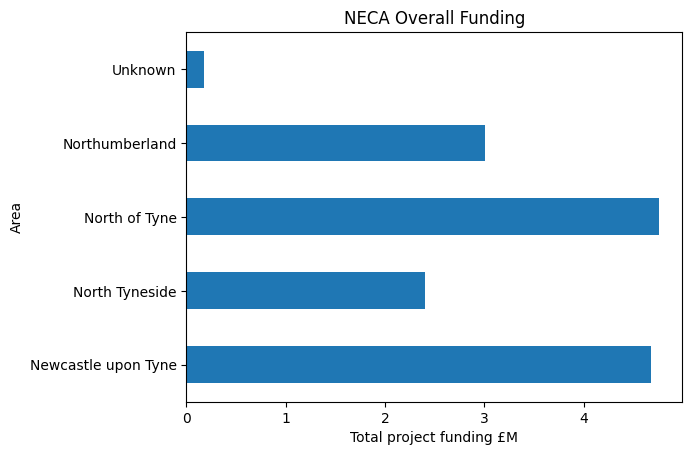

In [11]:
ax = df.Total.div(1e6).plot.barh(
    title="NECA Overall Funding",
    xlabel="Total project funding £M"
)

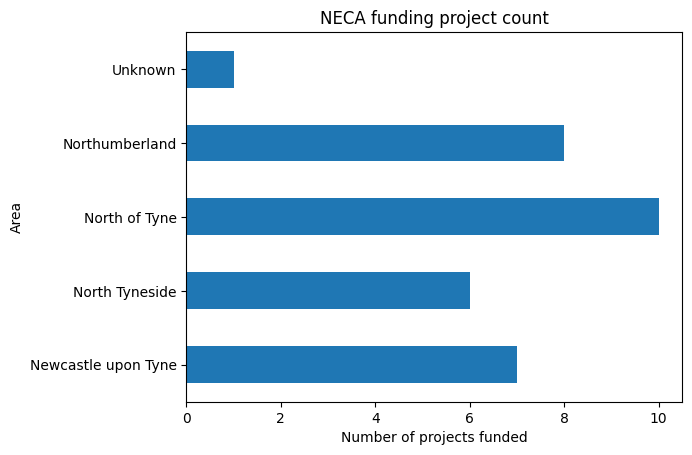

In [12]:
ax = df.Number.plot.barh(
    title="NECA funding project count",
    xlabel="Number of projects funded"
)

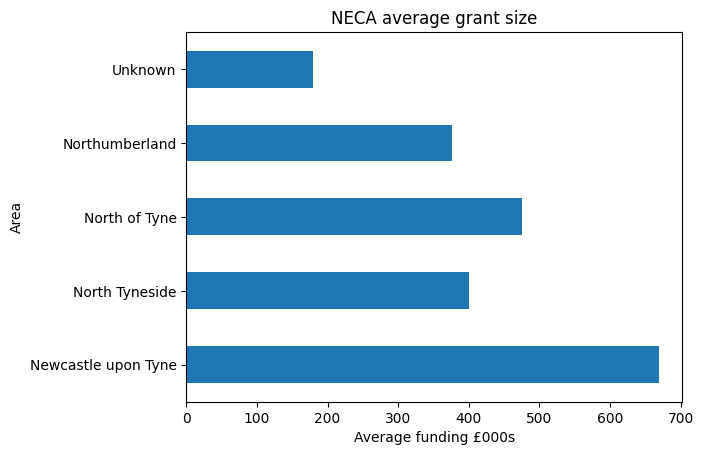

In [13]:
ax = df.Average.div(1e3).plot.barh(
    title="NECA average grant size",
    xlabel="Average funding £000s",
)